# CT inverse problem using the ideas of MACE from PnP MACE paper
https://github.com/gbuzzard/PnP-MACE/blob/master/demo/ct_demo.ipynb
- Phantom 
- MNIST digit
- TV denoising

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and TV denoising
from skimage.transform import radon, resize, iradon
from skimage.restoration import denoise_tv_chambolle
from skimage.data import shepp_logan_phantom

#Plug and Play with multi-adjusting consenus equilbrium
import pnp_mace as pnpm
from dotmap import DotMap

# Test image
phantom = shepp_logan_phantom()
num_scans = 180
angles = np.linspace(0., 360, num_scans, endpoint=False)
phantom_resized = resize(phantom, (200, 200), mode='reflect')

#Forward model (Radon transform) and FBP inversion
def A(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return radon(x, theta=angles, circle=True)

def AT(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return iradon(x, theta=angles, circle=True)

#Denoiser for the prior - can use any
def denoiser(x, params):
    denoised_x = denoise_tv_chambolle(x, weight=params.noise_std)
    return denoised_x

In [97]:
#Resizing
ground_truth = phantom/1000
imsize = None
cur_size = min(ground_truth.shape)

image_scale = 1

if imsize is not None and imsize != cur_size:
    image_scale = cur_size / imsize
    new_size = ground_truth.shape * image_scale
    ground_truth = resize(ground_truth, new_size.astype(int))

radius = min(ground_truth.shape) // 2

c0, c1 = np.ogrid[0:ground_truth.shape[0], 0:ground_truth.shape[1]]
mask = ((c0 - ground_truth.shape[0] // 2) ** 2
        + (c1 - ground_truth.shape[1] // 2) ** 2)
mask = (mask <= radius ** 2)
ground_truth = ground_truth * mask

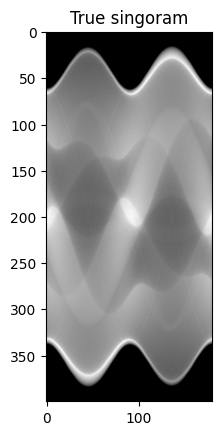

In [100]:

sinogram = A(phantom)

# Display the sinogram
plt.title('True singoram')
plt.imshow(sinogram, cmap='gray')



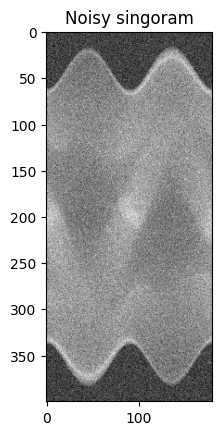

In [101]:
#Noisy sinogram

noise = 15 * np.random.standard_normal(sinogram.shape)

noisy_sinogram = sinogram + noise
plt.title('Noisy singoram')
plt.imshow(noisy_sinogram, cmap='gray')

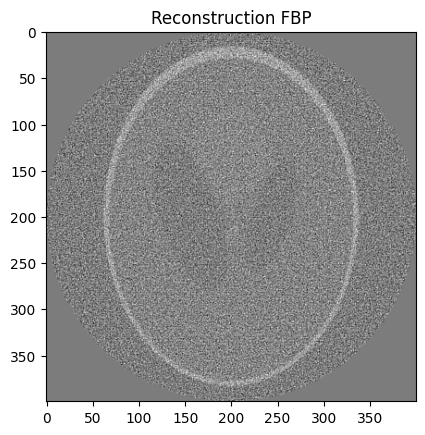

In [102]:
#FBP reconstruction
fbp_recon = iradon(sinogram, theta=angles, circle=True)
fbp_noisy_recon = iradon(noisy_sinogram, theta=angles, circle=True)

plt.title('Reconstruction FBP')
plt.imshow(fbp_noisy_recon, cmap='gray')

In [ ]:
#parameters
step_size = 0.1

# Forward agent (data fidelity term) that uses the A- radon and AT - FBP
forward_agent = pnpm.LinearProxForwardAgent(noisy_sinogram, A, AT, step_size)

In [104]:
#prior 
def prior_agent_method(x, params):
    denoised_x = denoiser(x, params)
    return mask * denoised_x

prior_params = DotMap()
prior_params.noise_std = step_size

prior_agent = pnpm.PriorAgent(prior_agent_method, prior_params)

In [105]:
#display results function


def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        cur_min = np.round(np.amin(img), 1)
        cur_max = np.round(np.amax(img), 1)
        bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        nrmse = pnpm.nrmse(img, ground_truth)
        titles.append(title + ' [NRMSE: ' + str(nrmse) +
                      ']\n (full range is ' + bounds + ' )')

    vmin = [0, 2]
    vmax = [2, 8]

    num_scales = len(vmin)

    for img, title in zip(image_list, titles):

        fig, ax = plt.subplots(nrows=1, ncols=num_scales,
                               figsize=(4.5*num_scales, 5))

        for k in range(num_scales):
            # display at various scales
            range_title = "Range: " + str(vmin[k]) + " to " + str(vmax[k])
            pnpm.display_image(img, title=range_title, fig=fig, ax=ax[k],
                               vmin=vmin[k], vmax=vmax[k], cmap='gray')
            #plt.colorbar()

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()


C:\Users\as5057\AppData\Local\Temp\ipykernel_26232\2520885660.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\as5057\AppData\Local\Temp\ipykernel_26232\2520885660.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


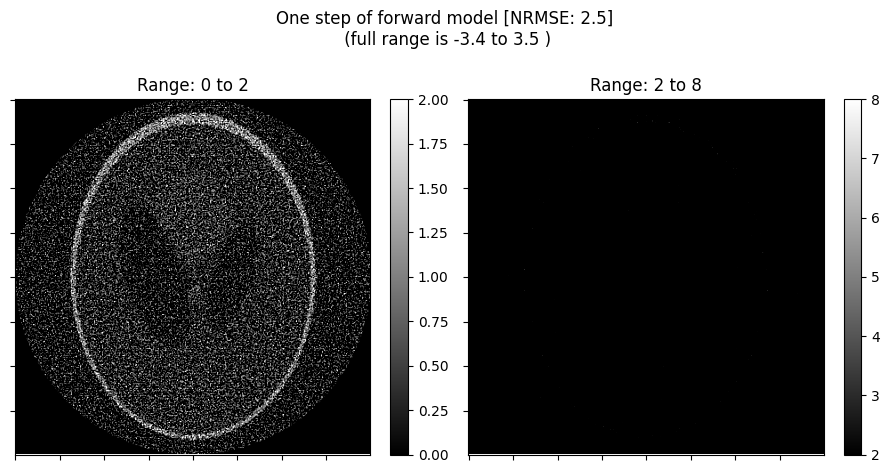

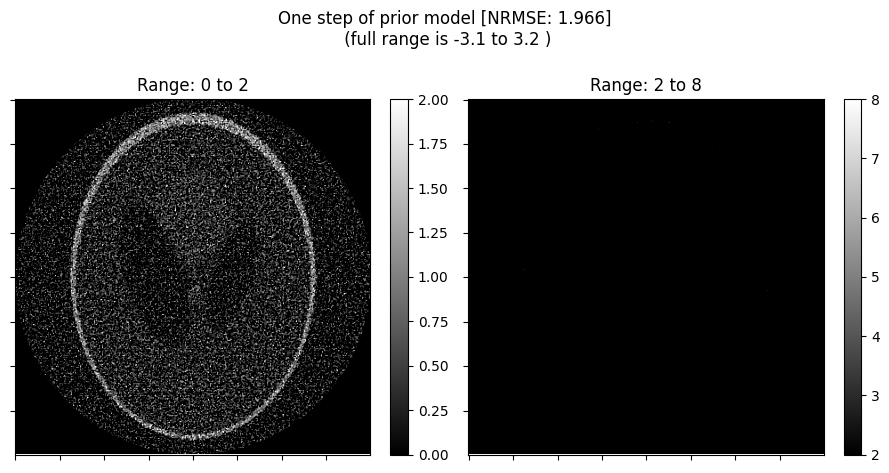

In [106]:
one_step_forward = forward_agent(np.asarray(fbp_noisy_recon))
one_step_prior = prior_agent(np.asarray(fbp_noisy_recon))

display_images([one_step_forward, one_step_prior], ['One step of forward model', 'One step of prior model'], phantom)

In [119]:
mu0 = 0.1 #forward weight
num_iters = 20
mu = [mu0, 1 - mu0]
rho = 0.5
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent, prior_agent]
#MACE setup
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(fbp_noisy_recon, len(agents))

In [120]:
final_images, residuals, vectors, all_images = equil_prob.solve(
    init_images)


Starting Mann iterations
Finished iteration 1 of 20
Finished iteration 2 of 20
Finished iteration 3 of 20
Finished iteration 4 of 20
Finished iteration 5 of 20
Finished iteration 6 of 20
Finished iteration 7 of 20
Finished iteration 8 of 20
Finished iteration 9 of 20
Finished iteration 10 of 20
Finished iteration 11 of 20
Finished iteration 12 of 20
Finished iteration 13 of 20
Finished iteration 14 of 20
Finished iteration 15 of 20
Finished iteration 16 of 20
Finished iteration 17 of 20
Finished iteration 18 of 20
Finished iteration 19 of 20
Finished iteration 20 of 20


C:\Users\as5057\AppData\Local\Temp\ipykernel_26232\2520885660.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\as5057\AppData\Local\Temp\ipykernel_26232\2520885660.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\as5057\AppData\Local\Temp\ipykernel_26232\2520885660.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


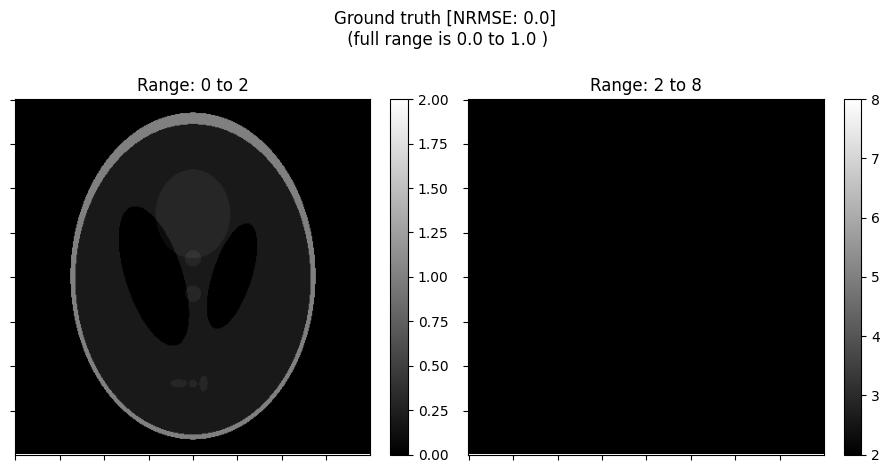

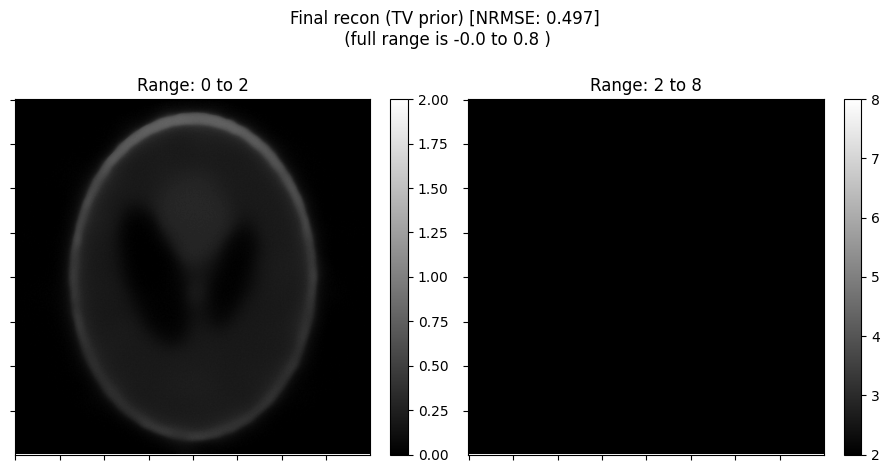

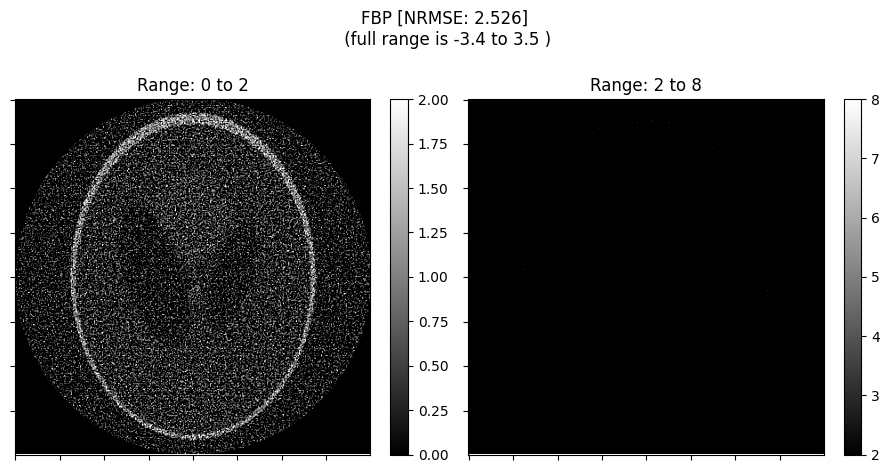

In [121]:
im = final_images[0]
display_images([phantom, im, fbp_noisy_recon], ['Ground truth', 'Final recon (TV prior)', 'FBP'], phantom)

In [111]:
from sklearn.datasets import fetch_openml

#MNIST data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True,
as_frame=False, parser="pandas")
x_3 = X[111].astype('double')
x_8 = X[333].astype('double')
imsize = (28, 28)


def trans(x):
    theta = range(0,359, 13)
    return radon(np.reshape(x, imsize), theta)

digit_sinogram = trans(x_3)

c:\Users\as5057\OneDrive - University of Bath\1st Year\TfR\.venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


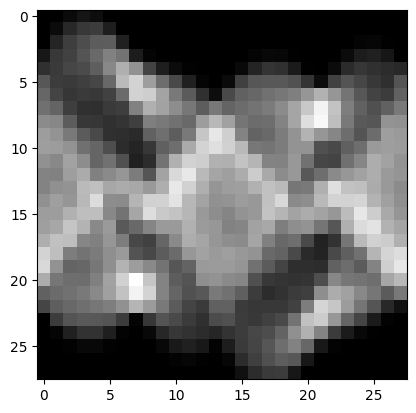

In [112]:
plt.imshow(np.reshape(digit_sinogram, imsize),cmap='gray')
noisy = 21 * np.random.standard_normal(digit_sinogram.shape)

noisy_digit = digit_sinogram + noisy

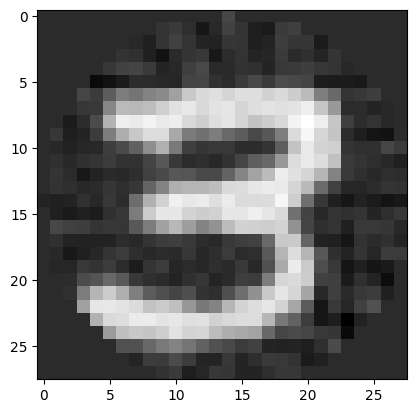

In [113]:
angles = range(0,359, 13)
fbp = iradon(digit_sinogram, theta=angles, circle=True)
fbp_noisy = iradon(noisy_digit, theta=angles, circle=True)
plt.imshow(fbp_noisy, cmap='gray')

In [114]:
#MNIST forward agent
forward_agent1 = pnpm.LinearProxForwardAgent(noisy_digit, A, AT, step_size)

In [86]:
mu0 = 0.6 #forward weight
num_iters = 10
mu = [mu0, 1 - mu0]
rho = 0.5
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent1, prior_agent]
#MACE setup
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(fbp_noisy, len(agents))

In [87]:
final_images, residuals, vectors, all_images = equil_prob.solve(
    init_images)


Starting Mann iterations


ValueError: operands could not be broadcast together with shapes (28,28) (28,180) 